In [ ]:
import random
import re, os
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
os.environ["PT_HPU_LAZY_MODE"] = "1"

In [ ]:
from habana_frameworks.torch.utils.library_loader import load_habana_module
load_habana_module()

In [ ]:
BASE_URL = './'
PATH = BASE_URL + 'final-merged-data-50.csv'

In [ ]:
RANDOM_SEED = 2
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
device = torch.device("hpu")

In [ ]:
raw_data_df = pd.read_csv(PATH)

In [ ]:
len(raw_data_df['song_id'].drop_duplicates())

1364

In [ ]:
raw_data_df.isna().sum()

Unnamed: 0    0
song_id       0
lyrics        0
streams       0
date          0
label         0
dtype: int64

In [ ]:
raw_data_df.head(1000)

,Unnamed: 0,song_id,lyrics,streams,date,label
0,0,1258,"Ayy I'm tryna put you in the worst mood, ah ...",3342769,2017-01-03,1
1,1,1218,"Hey, I was doing just fine before I met you I...",3019058,2017-01-03,1
2,2,315,Call it love and devotion Call it a mom's ado...,2726981,2017-01-03,1
3,3,329,I used to believe We were burnin' on the edge...,2524666,2017-01-03,1
4,4,886,"Oh, hey Oh, oh hey Oh, oh, oh hey Uh oh, uh o...",2362830,2017-01-03,1
...,...,...,...,...,...,...
995,3808,43,She just wants to be beautiful She goes unnot...,1116563,2017-01-31,0
996,3809,605,Let's go out and be wild Do it while we can ...,1098946,2017-01-31,0
997,3810,1126,I won't lie to you I know he's just not right...,1088492,2017-01-31,0
998,3811,50,"Listen, man What's up? I heard you done got y...",1079588,2017-01-31,0


In [ ]:
data_df = raw_data_df

In [ ]:
# Cast the numerical features to floats.
data_df['streams'] = data_df['streams'].astype('int32')

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55250 entries, 0 to 55249
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  55250 non-null  int64 
 1   song_id     55250 non-null  int64 
 2   lyrics      55250 non-null  object
 3   streams     55250 non-null  int32 
 4   date        55250 non-null  object
 5   label       55250 non-null  int64 
dtypes: int32(1), int64(3), object(2)
memory usage: 2.3+ MB


In [ ]:
class_names = ['bearish', 'bullish']

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'bearish'), Text(0, 0, 'bullish')]

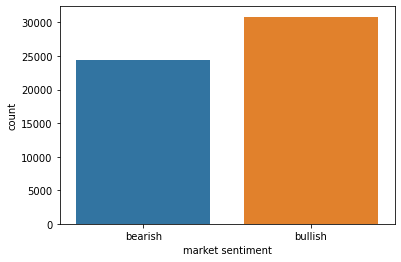

In [ ]:
ax = sns.countplot(data_df.label)
plt.xlabel('market sentiment')
ax.set_xticklabels(class_names)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Check for the max len of token through out the dataset
sen_w_feats = data_df['lyrics'].drop_duplicates()
max_len = 0
size = []
# For every sentence...
for sent in sen_w_feats:
    if sent != None or sent != '':
      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(sent, add_special_tokens=True)
      size.append(len(input_ids))
      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)
print('Avg Length: ', sum(size)/len(size))
print('50th Percentile', np.percentile(size, 50))
print('90th Percentile', np.percentile(size, 90))

Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1918
Avg Length:  580.1852986217458
50th Percentile 537.5
90th Percentile 899.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


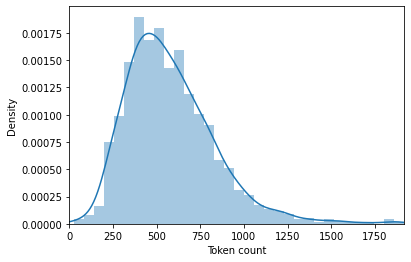

In [ ]:
sns.distplot(size)
plt.xlim([0, max_len]);
plt.xlabel('Token count');

Train Test Val Split

In [ ]:
# Larger batch sizes tend to be better, and we can fit this in memory.
BATCH_SIZE = 32

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
LR = 2e-5

# Number of training epochs. 
EPOCHS = 6
MAX_LEN = 250
TRAIN_TEST_SPLIT = 0.3
TEST_VAL_SPLIT = 0.1
N_CLASSES = 2

In [ ]:
def group_array(data_df, column):
  gb = data_df.groupby([column])
  return [gb.get_group(x) for x in gb.groups]

In [ ]:
group_arr = group_array(data_df, 'date')

In [ ]:
dataset = np.array([np.array(x) for x in group_arr])

In [ ]:
dataset_train, dataset_test = train_test_split(
  dataset,
  test_size=TRAIN_TEST_SPLIT,
  random_state=RANDOM_SEED
)

In [ ]:
dataset_test, dataset_val = train_test_split(
  dataset_test,
  test_size=TEST_VAL_SPLIT,
  random_state=RANDOM_SEED
)

In [ ]:
print("Shape of the Training Dataset", dataset_train.shape)
print("Shape of the Test Dataset", dataset_test.shape)
print("Shape of the Validation Dataset", dataset_val.shape)

Shape of the Training Dataset (773, 50, 6)
Shape of the Test Dataset (298, 50, 6)
Shape of the Validation Dataset (34, 50, 6)


In [ ]:
def middle_list(sentences, min_lenght):
  length = len(sentences)
  if length > min_lenght:
    half = length / 2
    half = int(half)
    quad = half / 2
    quad = int(quad)
    sentences = sentences[quad:quad+half]
  return sentences


In [ ]:
def preprocess_lyrics(text):
  sentences = list(set(re.split("  +", text)))
  sentences = middle_list(sentences, 10)
  text_new = ". ".join(sentences)
  sentences = list(re.split(" +", text))
  sentences = middle_list(sentences, 200)
  return " ".join(sentences)

In [ ]:
class LyricsDataset(Dataset):

  def __init__(self, dataset, max_len, tokenizer):
    self.dataset = dataset[:, :, 1:]
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, item):
    idata = self.dataset[item]
    target = idata[:,-1].max()
    sen_w_feats = idata[:, 1]
    input_ids = []
    attention_masks = []
    for sent in sen_w_feats:
      sent = preprocess_lyrics(sent)
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = self.max_len,           # Pad & truncate all sentences.
                          truncation = True,
                          padding = 'max_length',
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                  )
          # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.stack(input_ids)
    input_ids_shape = input_ids.size()
    input_ids = torch.reshape(input_ids, (input_ids_shape[0], input_ids_shape[2]))
    attention_masks = torch.stack(attention_masks)
    attention_masks_shape = attention_masks.size()
    attention_masks = torch.reshape(attention_masks, (attention_masks_shape[0], attention_masks_shape[2]))
    return {
        "input_ids":input_ids,
        "attention_mask":attention_masks,
        "streams": torch.from_numpy(idata[:,2].astype('int64')),
        "targets": torch.tensor(target, dtype=torch.long)
    }


In [ ]:
def create_data_loader(dataset, tokenizer, max_len, batch_size):
  ds = LyricsDataset(
    dataset=dataset,
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
train_data_loader = create_data_loader(dataset_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(dataset_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(dataset_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))

In [ ]:
data.keys()

dict_keys(['input_ids', 'attention_mask', 'streams', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['streams'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 50, 10])
torch.Size([16, 50])
torch.Size([16, 50, 10])
torch.Size([16])


In [ ]:
# Mapping Layer that maps songs to the mapping table
class MappingLayer(nn.Module):
  def __init__(self, group_column='date'):
    super(MappingLayer, self).__init__()
  
  def forward(self, bert_output, streams):
    out = bert_output * streams.unsqueeze(-1)
    return out.mean(dim=1)

In [ ]:
# Lyrics Sentiment Classifier uses BERT MODEL and Linear Classifier
class LyricsSentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(LyricsSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.dropout = nn.Dropout(p=0.1)
    self.mapping = MappingLayer()
    self.linear = nn.Linear(self.bert.config.hidden_size, 256)
    self.hidden = nn.Linear(256, n_classes)
    self.sigmoid = nn.Sigmoid()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask, streams):
    base_model_output = self.bert(
      input_ids=input_ids, attention_mask=attention_mask
    )
    pooler_output = base_model_output.pooler_output
    bert_output = self.dropout(pooler_output)
    x_dim = bert_output.shape[0]/50
    x = bert_output.reshape(int(x_dim), 50, self.bert.config.hidden_size)
    x = self.mapping(x, streams)
    x = self.linear(x)
    x = self.hidden(x)
    x = self.sigmoid(x)
    return self.softmax(x)

In [ ]:
model = LyricsSentimentClassifier(N_CLASSES)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=LR, correct_bias=False)
total_steps =  EPOCHS * BATCH_SIZE
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=2,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    # Unpack the inputs
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    input_ids = input_ids.reshape(input_ids.shape[0]*input_ids.shape[1], input_ids.shape[2])
    attention_mask = attention_mask.reshape(attention_mask.shape[0]*attention_mask.shape[1], attention_mask.shape[2])
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    streams = d['streams'].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      streams=streams
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

Evaluation

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      # Unpack the inputs
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      input_ids = input_ids.reshape(input_ids.shape[0]*input_ids.shape[1], input_ids.shape[2])
      attention_mask = attention_mask.reshape(attention_mask.shape[0]*attention_mask.shape[1], attention_mask.shape[2])
      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      streams = d['streams'].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        streams=streams
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 50)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(dataset_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(dataset_test)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    model.to("cpu")
    torch.save(model.state_dict(), 'best_model_state.bin')
    model.to(device)
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
plt.plot(history['train_loss'])

Loading Models & Validation

In [ ]:
model = LyricsSentimentClassifier(N_CLASSES)
model.load_state_dict(torch.load("best_model_state.bin"))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
# model.eval()

In [ ]:
with torch.no_grad():
  n_examples = len(dataset_val)
  for d in val_data_loader:
    # Unpack the inputs
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    input_ids = input_ids.reshape(input_ids.shape[0]*input_ids.shape[1], input_ids.shape[2])
    attention_mask = attention_mask.reshape(attention_mask.shape[0]*attention_mask.shape[1], attention_mask.shape[2])
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    streams = d['streams'].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      streams=streams
    )
    _, preds = torch.max(outputs, dim=1)

val_acc = preds.eq(targets).sum()/len(targets) * 100
print("Accuracy on the validation data: ", val_acc)

Accuracy on the validation data:  tensor(50.)
